In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 特徴量のリスト
features = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
    "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# データの読み込み
data = pd.read_csv('NSL-KDD/KDDTrain+.txt', sep=',', header=None, names=features)
target = data['label'].copy()
data.drop(["service", "land", "protocol_type", "flag", "is_host_login", "logged_in", "is_guest_login", "label", "difficulty"], axis=1, inplace=True)

# ラベルの置換
# 正常: 0, 攻撃: 1
target[target != 'normal'] = 1
target[target == 'normal'] = 0

# データの確認
#print(data.head())
#print(target.head())
print(target.value_counts())
#print(target.shape)
#print(f"Data shape: {data.shape}")
#print(f"Columns: {data.columns}")


label
0    67343
1    58630
Name: count, dtype: int64


In [3]:
# trainデータを分割して学習データとテストデータに分ける
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

# ラベルの型をintに変換
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# インデックスをリセット
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

Accuracy of RandomForest: 0.9982800592718035


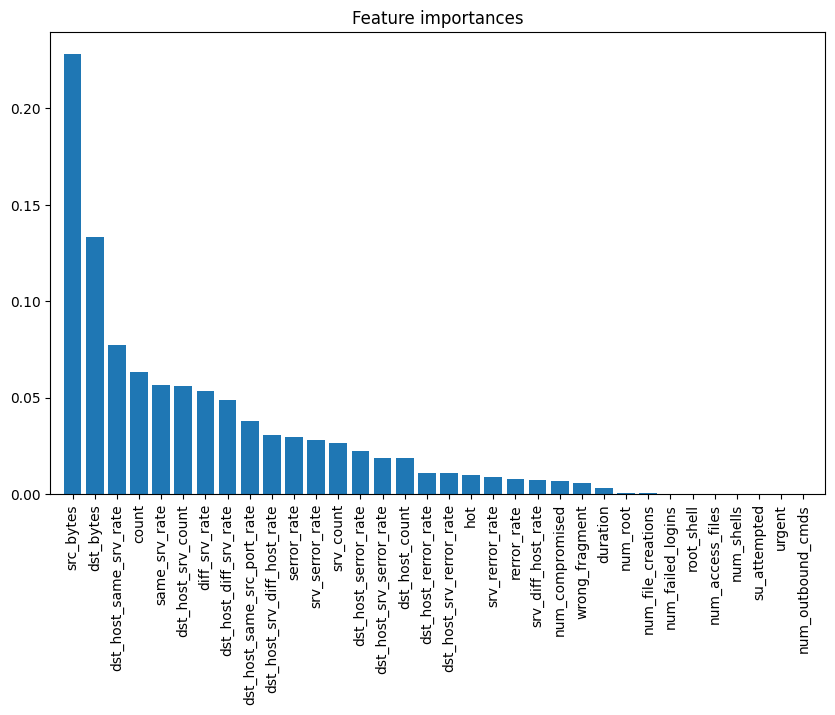

In [4]:
# 機械学習モデルの作成
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# データの標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# numpy配列をDataFrameに変換
X_train = pd.DataFrame(X_train, columns=data.columns)
X_test = pd.DataFrame(X_test, columns=data.columns)

# ランダムフォレストの作成
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ランダムフォレストの精度
y_pred = model.predict(X_test)
print(f"Accuracy of RandomForest: {accuracy_score(y_test, y_pred)}")

# 特徴量の重要度
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), data.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [5]:
# ナイーブなiforest
from sklearn.ensemble import IsolationForest

# iforestのモデル作成
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train)

# テストデータでの精度
y_pred_naive = model.predict(X_test)
y_pred_naive = np.where(y_pred_naive == -1, 1, 0)
print(f"Accuracy of Naive Iforest: {accuracy_score(y_test, y_pred_naive)}")


Accuracy of Naive Iforest: 0.5623676968670618


In [6]:
# 異常と正常データに分割して、それぞれでモデルをトレーニング
X_train_normal = X_train[y_train == 0]
X_train_anomaly = X_train[y_train == 1]
print(f"Normal data shape: {X_train_normal.shape}")
print(f"Anomaly data shape: {X_train_anomaly.shape}")

model_normal = IsolationForest(contamination=0.1, random_state=42)
model_anomaly = IsolationForest(contamination=0.1, random_state=42)

model_normal.fit(X_train_normal)
model_anomaly.fit(X_train_anomaly)

# テストデータでの精度(特徴量選択なし)
y_pred_normal = model_normal.predict(X_test)
y_pred_normal = np.where(y_pred_normal == -1, 1, 0)

y_pred_anomaly = model_anomaly.predict(X_test)
y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1)

print(f"Accuracy of Normal machine: {accuracy_score(y_test, y_pred_normal)}")
print(f"Accuracy of Attack machine: {accuracy_score(y_test, y_pred_anomaly)}")

# 結果を組み合わせた精度
# (Normal, Attack) = (0, 0) -> 0 (normal)
# (Normal, Attack) = (0, 1) -> 1（anomaly）
# (Normal, Attack) = (1, 0) -> -1 (unknown)
# (Normal, Attack) = (1, 1) -> 1 (anomaly)

y_pred = np.where((y_pred_normal == 0) & (y_pred_anomaly == 0), 0, 0)
y_pred = np.where((y_pred_normal == 0) & (y_pred_anomaly == 1), 1, y_pred)
y_pred = np.where((y_pred_normal == 1) & (y_pred_anomaly == 0), -1, y_pred)
y_pred = np.where((y_pred_normal == 1) & (y_pred_anomaly == 1), 1, y_pred)

print(f"Accuracy of Combined machine: {accuracy_score(y_test, y_pred)}")

Normal data shape: (47182, 34)
Anomaly data shape: (40999, 34)
Accuracy of Normal machine: 0.9114098221845893
Accuracy of Attack machine: 0.48356795088907706
Accuracy of Combined machine: 0.44358594411515667


In [7]:
# 不必要な特徴量を削除
important_features = importances > 0.05

X_test_dropped = X_test[data.columns[important_features]]
X_train_anomaly_dropped = X_train_anomaly[data.columns[important_features]]
X_train_normal_dropped = X_train_normal[data.columns[important_features]]

In [8]:
# モデルの作成
model_normal = IsolationForest(contamination=0.1, random_state=42)
model_anomaly = IsolationForest(contamination=0.1, random_state=42)

model_normal.fit(X_train_normal_dropped)
model_anomaly.fit(X_train_anomaly_dropped)

# テストデータでの精度
y_pred_normal = model_normal.predict(X_test_dropped)
y_pred_normal = np.where(y_pred_normal == -1, 1, 0) # -1(anomaly)を1(attack)に変換, 1(normal)を0(normal)に変換

y_pred_anomaly = model_anomaly.predict(X_test_dropped)
y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1) # -1(anomaly)を0(normal)に変換, 1(normal)を1(attack)に変換

print(f"Accuracy of normal: {accuracy_score(y_test, y_pred_normal)}")
print(f"Accuracy of attack: {accuracy_score(y_test, y_pred_anomaly)}")

# 結果を組み合わせた精度
y_pred = np.where((y_pred_normal == 0) & (y_pred_anomaly == 0), 0, 0)
y_pred = np.where((y_pred_normal == 0) & (y_pred_anomaly == 1), 1, y_pred)
y_pred = np.where((y_pred_normal == 1) & (y_pred_anomaly == 0), -1, y_pred) 
y_pred = np.where((y_pred_normal == 1) & (y_pred_anomaly == 1), 1, y_pred)

print(f"Accuracy of combined machine: {accuracy_score(y_test, y_pred)}")


Accuracy of normal: 0.8645215918712955
Accuracy of attack: 0.860684801016088
Accuracy of combined machine: 0.8088748941574937


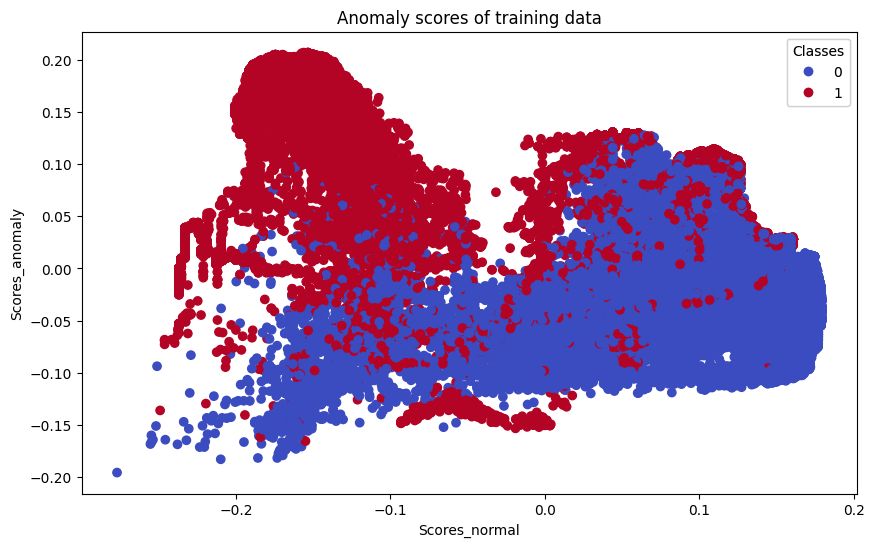

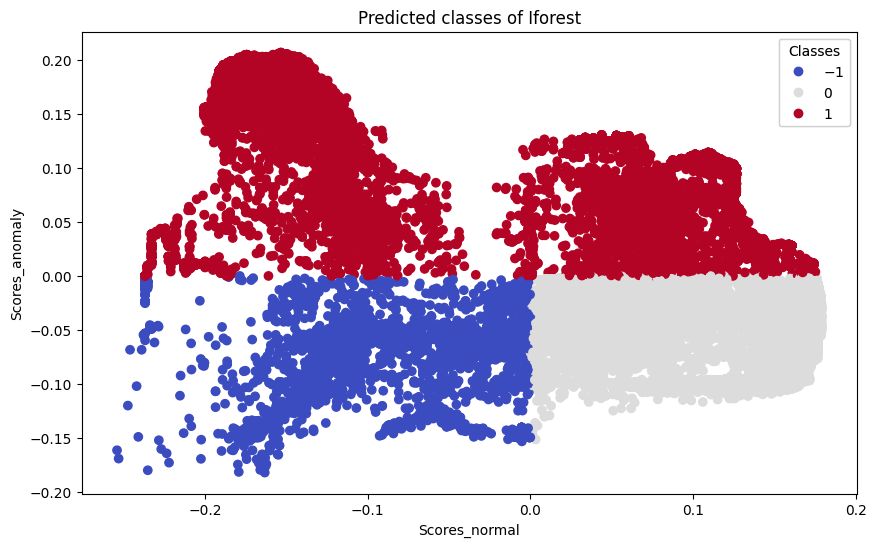

In [9]:
# トレーニングデータのそれぞれの判定器で計算した異常スコアを取得
X_train_dropped = X_train[data.columns[important_features]]
scores_train_normal = model_normal.decision_function(X_train_dropped)
scores_train_anomaly = model_anomaly.decision_function(X_train_dropped)
scores_train = np.column_stack((scores_train_normal, scores_train_anomaly))

# テストデータの異常スコアの取得
scores_normal = model_normal.decision_function(X_test_dropped)
scores_anomaly = model_anomaly.decision_function(X_test_dropped)
scores = np.column_stack((scores_normal, scores_anomaly))

# トレーニングデータの異常スコアをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores_train[:, 0], scores_train[:, 1], c=y_train, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.title("Anomaly scores of training data")
plt.show()

# 予測したクラスをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=y_pred, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("Predicted classes of Iforest")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()


Accuracy of Iforest with LogisticRegression: 0.9197978408128704


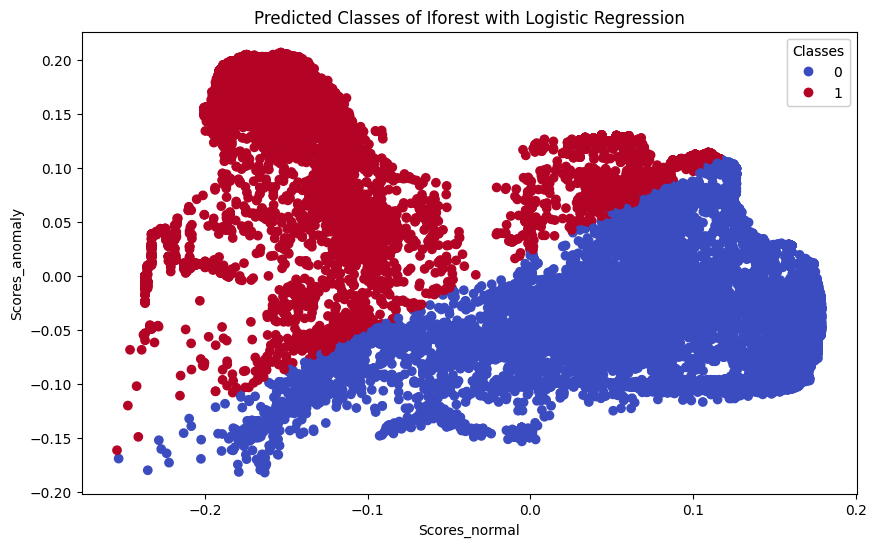

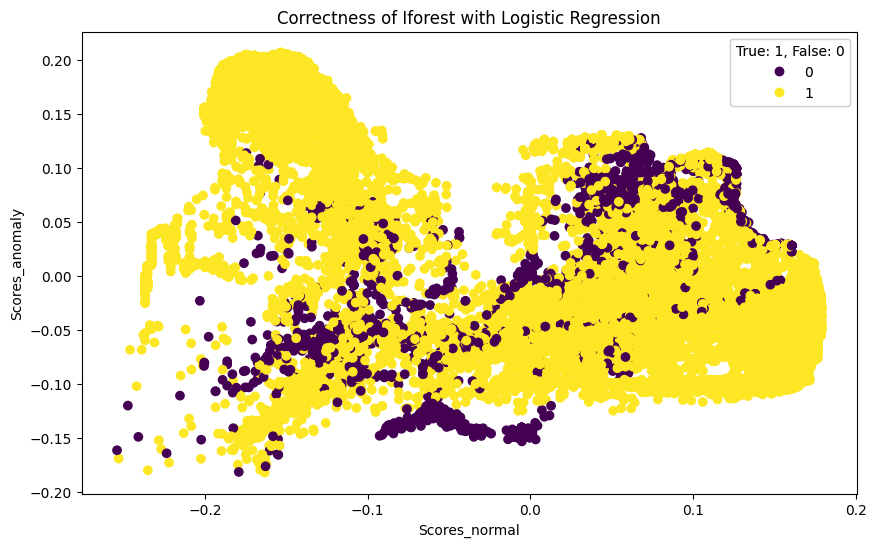

In [10]:
# ロジスティック回帰を用いてラベルを予測
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルの作成
model_LR = LogisticRegression()
model_LR.fit(scores_train, y_train)

# ラベルの予測
y_pred = model_LR.predict(scores)
#print(f"y_pred: {y_pred}")
print(f"Accuracy of Iforest with LogisticRegression: {accuracy_score(y_test, y_pred)}")

# 予測したラベルをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=y_pred, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("Predicted Classes of Iforest with Logistic Regression")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()

# 正解不正解をプロット
labels = np.where(y_test == y_pred, 1, 0) # 1: 正解, 0: 不正解

plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=labels, cmap="viridis")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("Correctness of Iforest with Logistic Regression")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True: 1, False: 0")
plt.gca().add_artist(legend1)
plt.show()
